In [1]:
import os
import sys
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from bm_functions import get_correlation_df
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.cluster.hierarchy import linkage, leaves_list

module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch


Calculating SVGs: 100%|██████████| 12409/12409 [01:46<00:00, 116.98it/s]


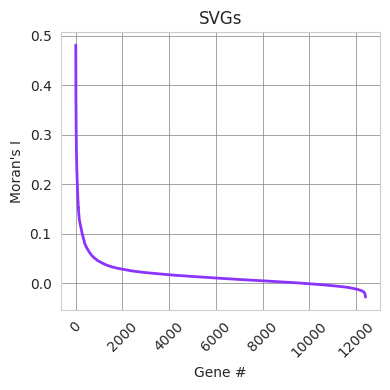

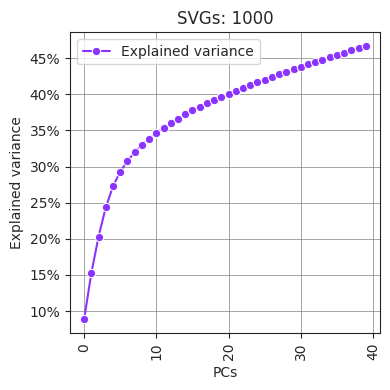

In [2]:
# read sample
sample_hash = 'b65e3087321c'
adp = f'/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune/{sample_hash}/{sample_hash}_sth_adata.h5ad'

sample_folder = '/'.join(adp.split('/')[:-1]) + '/'
adata = sc.read_h5ad(adp)

# chrysalis for the selected sample
# number of non-uniform compartments
uniform = int(adata.uns['parameters']['n_tissue_zones'] * adata.uns['parameters']['uniform'])
n_tissue_zones = adata.uns['parameters']['n_tissue_zones'] - uniform
n_tissue_zones = int(n_tissue_zones)

# chrysalis pipeline
ch.detect_svgs(adata, neighbors=8, top_svg=1000, min_morans=0.01)
ch.plot_svgs(adata)
plt.show()

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

ch.pca(adata, n_pcs=40)

ch.plot_explained_variance(adata)
plt.show()

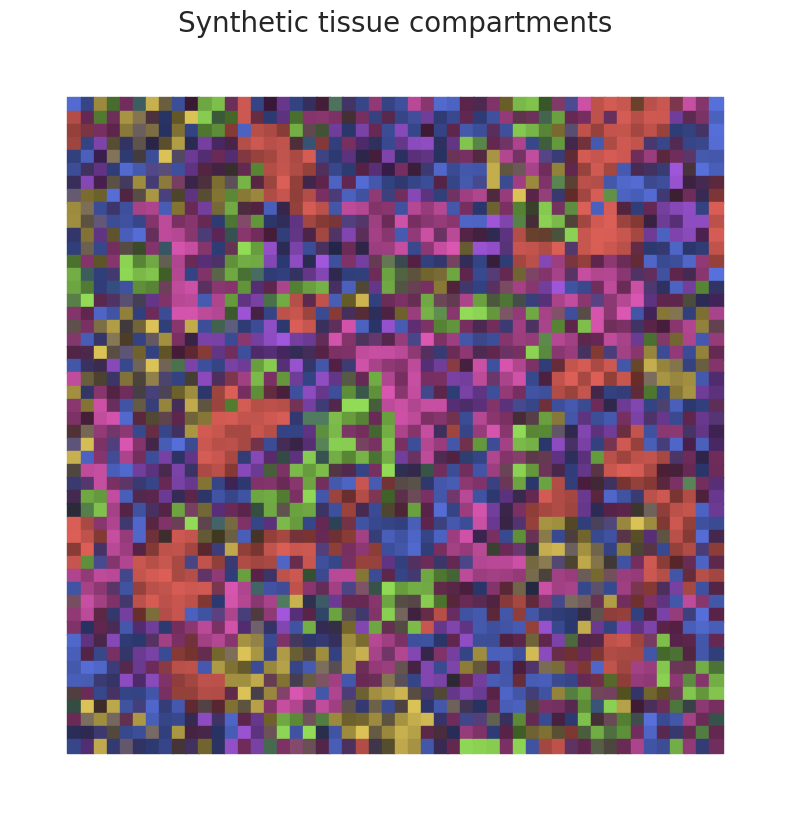

In [3]:
ch.aa(adata, n_pcs=20, n_archetypes=n_tissue_zones)

plt.rcParams['svg.fonttype'] = 'none'
ch.plot(adata, dim=n_tissue_zones, marker='s', figsize=(10, 10), rasterized=True)
plt.title('Synthetic tissue compartments', size=20)
plt.show()


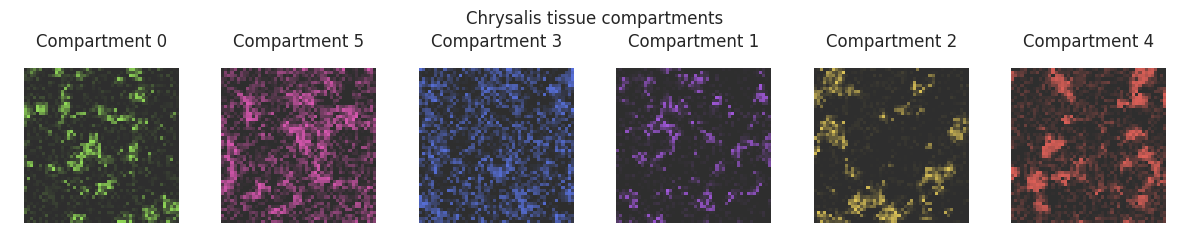

In [4]:

plt.rcParams['svg.fonttype'] = 'none'
fig, axs = plt.subplots(1, 6, figsize=(12, 2.5))
axs = axs.flatten()
for a in axs:
    a.axis('off')
plt.subplots_adjust(hspace=0.05, wspace=0.01, left=0.05, right=0.95, top=0.95, bottom=0.05)
hexcodes = ['#91db57', '#a157db', '#dbc257', '#5770db', '#db5f57', '#db57b2']
for idx, i in enumerate([0, 5, 3, 1, 2, 4]):
    ch.plot_compartment(adata, fig, axs[idx], dim=6, selected_dim=i, color_first='#2e2e2e',
                        spot_size=2.9, hexcodes=hexcodes, rasterized=True, marker='s', rotation=45)
    axs[idx].set_title(f'Compartment {i}')
plt.suptitle('Chrysalis tissue compartments')
plt.tight_layout()
plt.show()

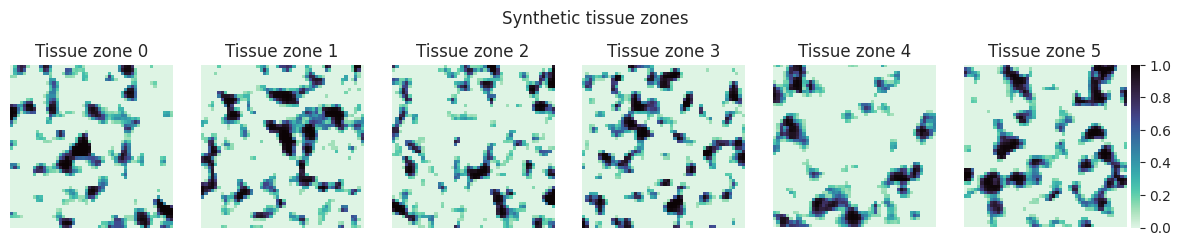

In [5]:
tissue_zones = adata.obsm['tissue_zones']

n_cell_types = tissue_zones.shape[1]
n1, n2 = (50, 50)
ncols = 6
nrows = 1

plt.rcParams['svg.fonttype'] = 'none'
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 2.5))
axs = axs.flatten()
for ax, ct in zip(axs, tissue_zones.columns):
    img_data = tissue_zones[ct].values.reshape(n1, n2).T
    im = ax.imshow(img_data, cmap='mako_r', vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.axis('off')
    ax.set_title(ct.capitalize().replace('_', ' '))
    ax.axis('off')

cax.axis('on')
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_frame_on(False)
plt.suptitle('Synthetic tissue zones')
plt.tight_layout()
plt.show()


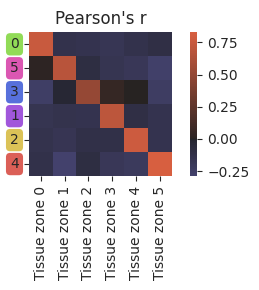

In [6]:
corr_df = pd.read_csv(sample_folder + 'chrysalis_pearson.csv', index_col=0)
corr_df.columns = [ct.capitalize().replace('_', ' ') for ct in corr_df.columns]
order = [0, 5, 3, 1, 2, 4]
corr_df = corr_df.loc[order, :]
hexcodes = ['#91db57', '#a157db', '#dbc257', '#5770db', '#db5f57', '#db57b2']
hexcodes = [hexcodes[h] for h in order]

plt.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.heatmap(corr_df, ax=ax, cmap=sns.diverging_palette(267, 20, l=55, center="dark", as_cmap=True), square=True,
            rasterized=True, center=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
for idx, t in enumerate(ax.get_yticklabels()):
    t.set_bbox(dict(facecolor=hexcodes[idx], alpha=1, edgecolor='none', boxstyle='round'))
plt.title("Pearson's r")
plt.tight_layout()
plt.show()


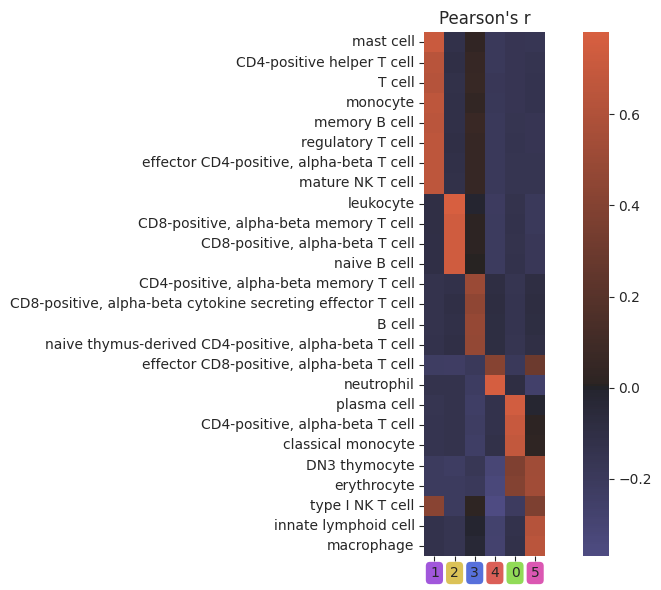

In [7]:
cell_types = adata.obsm['cell_abundance']
compartments = adata.obsm['chr_aa']
compartment_df = pd.DataFrame(data=compartments, index=adata.obs.index)

corr_df = get_correlation_df(cell_types, compartment_df)

Z = linkage(corr_df.T, method='ward')
order = leaves_list(Z)
corr_df = corr_df.iloc[:, order]
corr_df = corr_df.T
corder = [1, 2, 3, 4, 0, 5]
corr_df = corr_df[corder]

hexcodes = ['#91db57', '#a157db', '#dbc257', '#5770db', '#db5f57', '#db57b2']
hexcodes = [hexcodes[h] for h in corder]

plt.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(corr_df, ax=ax, cmap=sns.diverging_palette(267, 20, l=55, center="dark", as_cmap=True), square=True,
            rasterized=True, center=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for idx, t in enumerate(ax.get_xticklabels()):
    t.set_bbox(dict(facecolor=hexcodes[idx], alpha=1, edgecolor='none', boxstyle='round'))
plt.title("Pearson's r")
plt.tight_layout()
plt.show()
